In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from models.soft_actor_critic import SoftActorCritic
from models.ddpg import DDPG
# from rl_models_.her import HindsightExperienceReplay
from her2 import Player
# from rl_models.her import HindsightExperienceReplay
from rl_models.her_old import HindsightExperienceReplay
from rl_models.replay_buffer import ReplayBuffer
from rl_models.utils import plot_learning_curve

In [2]:
env_name = 'FetchPush-v2'
max_episode_steps = 50
env = gym.make(env_name, max_episode_steps=max_episode_steps)

env.action_space, env.observation_space

(Box(-1.0, 1.0, (4,), float32),
 Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (25,), float64)))

In [3]:
state_dim = env.observation_space['observation'].shape[0]
goal_dim = env.observation_space['desired_goal'].shape[0]
actions_dim = env.action_space.shape[0]
state_dim, actions_dim

(25, 4)

In [4]:
epochs = 100
epoch_iters = 50
success_history = []
batch_size = 256
gamma = .98

In [5]:
desired_goal = env.reset()[0]['desired_goal']

In [6]:
env2 = gym.make(env_name, max_episode_steps=max_episode_steps)
agent = DDPG(state_dim + goal_dim, actions_dim, 
             hidden_size=128, lr=1e-3,
              tau=0.05, gamma=gamma)
replay_buffer = ReplayBuffer(int(1e6))
player = Player(env, agent, replay_buffer)

In [7]:
agent2 = SoftActorCritic(state_dim + goal_dim, actions_dim, 
                         hidden_size=128, lr=1e-3,
              tau=0.05, gamma=gamma)
replay_buffer2 = ReplayBuffer(int(1e6))
player2 = Player(env2, agent2, replay_buffer2)

In [8]:
# env2 = gym.make(env_name, max_episode_steps=max_episode_steps)
# agent2 = SoftActorCritic(state_dim + goal_dim, actions_dim, hidden_size=256, 
#                          lr=1e-3, tau=0.05, gamma=gamma)
# replay_buffer2 = ReplayBuffer(1000000)
# her2 = HindsightExperienceReplay(env2, agent2, replay_buffer2, 
#                                 batch_size=batch_size, max_steps=max_episode_steps)

In [9]:
# env3 = gym.make(env_name, max_episode_steps=max_episode_steps)
# agent3 = SoftActorCritic(state_dim + goal_dim, actions_dim, hidden_size=64, 
#                          lr=1e-3, tau=0.95, gamma=gamma)
# replay_buffer3 = ReplayBuffer(1000000)
# her3 = HindsightExperienceReplay(env3, agent3, replay_buffer3, 
#                                 batch_size=batch_size, max_steps=max_episode_steps,
#                                 one_goal_task=desired_goal)

In [10]:
# her2.play_and_learn()

In [11]:
success_history2 = []
success_history3 = []

Epoch 7
DDPG with HER       success rate = 0.06375
Soft-Actor Critic with HER      success rate = 0.05875


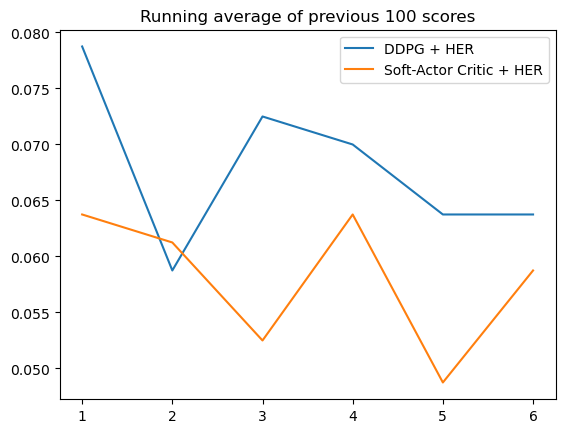

  4%|▍         | 2/50 [00:09<03:56,  4.94s/it]

In [12]:
epsilon = .3
for epoch in range(epochs):
    score_history = []
    score_history2 = []
    score_history3 = []


    for iter in tqdm(range(epoch_iters)):
        score, success = player.play_and_record(epsilon=epsilon)
        player.update_agent()
        score_history.append(float(success))

        score, success = player2.play_and_record(epsilon=epsilon)
        player2.update_agent()
        score_history2.append(float(success))

        # score, success = her2.play_and_learn(num_episodes=16)
        # score_history2.append(float(success))

        # score, success = her3.play_and_learn(num_episodes=16, her=False)
        # score_history3.append(float(success))
    if epsilon > 0:
        epsilon -= 0.005

    success_rate = np.mean(score_history)
    success_history.append(success_rate)
    plot_learning_curve(len(success_history), success_history, name="DDPG + HER") 

    success_rate2 = np.mean(score_history2)
    success_history2.append(success_rate2)
    plot_learning_curve(len(success_history2), success_history2, name="Soft-Actor Critic + HER") 

    # success_rate3 = np.mean(score_history3)
    # success_history3.append(success_rate3)
    # plot_learning_curve(len(success_history3), success_history3, name="Soft-Actor Critic without HER", running=True) 

    print(f"Epoch {len(success_history) + 1}")
    print(f"DDPG with HER       success rate = {success_rate}")
    print(f"Soft-Actor Critic with HER      success rate = {success_rate2}")
    # print(f"Soft-Actor Critic without HER       success rate = {success_rate3}")
    plt.show()